# Clustering: Data Labeling

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import swifter

from ast import literal_eval
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample

In [21]:
indoset_lexicon_neg_path = '../dataset/wordlist/indoset_lexicon_neg.csv'
indoset_lexicon_pos_path = '../dataset/wordlist/indoset_lexicon_pos.csv'
vulgarity_lexicon_path = '../dataset/wordlist/vulgarity_lexicon.csv'

target = 'tweets.csv'
processed_target_path = f'../dataset/processed/processed_{target}'
output_path = f'../dataset/processed/supervised_{target}'

In [22]:
indoset_lexicon_neg = pd.read_csv(indoset_lexicon_neg_path, delimiter='\t')
indoset_lexicon_pos = pd.read_csv(indoset_lexicon_pos_path, delimiter='\t')
vulgarity_lexicon = pd.read_csv(vulgarity_lexicon_path, header=None, delimiter='\t')

print(f"Total lexicon neg:", len(indoset_lexicon_neg))
print(f"Total lexicon pos:", len(indoset_lexicon_pos))
print(f"Total lexicon vulgarity:", len(vulgarity_lexicon))

Total lexicon neg: 6609
Total lexicon pos: 3609
Total lexicon vulgarity: 62


In [23]:
# def update_lexicon_row(row=None, col_name="", df=pd.DataFrame(), pkey=""):
# 	try:
# 		match_index = df.loc[df[pkey] == col_name].index[0]
# 		row = df.loc[match_index]
# 	except IndexError:
# 		pass
# 	finally:
# 		return row

# def combine_lexicons(parent_lex, child_lex, pkey):
# 	filtered_lex = child_lex[child_lex[pkey].isin(parent_lex[pkey])]
# 	parent_lex[parent_lex[pkey].isin(child_lex[pkey])] = parent_lex[parent_lex[pkey].isin(child_lex[pkey])].apply(lambda row: update_lexicon_row(row, row[pkey], filtered_lex, pkey), axis=1)
# 	parent_lex = pd.concat([parent_lex, child_lex]).drop_duplicates(subset=[pkey])
# 	return parent_lex.reset_index(drop=True)

lexicon_dict = pd.concat([indoset_lexicon_pos, indoset_lexicon_neg], ignore_index=True)

vulgarity_lexicon_weight = [-5 for word in vulgarity_lexicon[0]]
vulgarity_lexicon = pd.DataFrame(list(zip(vulgarity_lexicon[0],vulgarity_lexicon_weight)),columns =['word','weight'])


lexicon_dict = pd.concat([lexicon_dict, vulgarity_lexicon], ignore_index=True)
print(len(lexicon_dict))
lexicon_dict

10280


,word,weight
0,hai,3
1,merekam,2
2,ekstensif,3
3,paripurna,1
4,detail,2
...,...,...
10275,sontoloyo,-5
10276,syaithon,-5
10277,tai,-5
10278,telek,-5


Total negative lexicon: 6671
Total positive lexicon: 3609


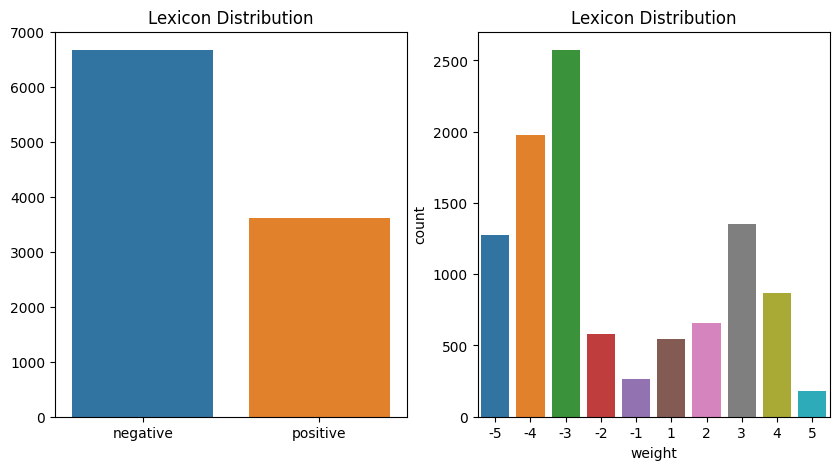

In [24]:
# count how many negative words in lexicon_dict
neg_lexicon = lexicon_dict[lexicon_dict['weight'] < 0]
pos_lexicon = lexicon_dict[lexicon_dict['weight'] >= 0]
print(f"Total negative lexicon:", len(neg_lexicon))
print(f"Total positive lexicon:", len(pos_lexicon))

plt.figure(figsize=(10,5))
# make bar plot from negative and positive lexicon
plt.subplot(1,2,1)
sns.barplot(x=['negative','positive'], y=[len(neg_lexicon), len(pos_lexicon)])
plt.title('Lexicon Distribution')
# visualize the amount of negative and positive words based on weight in lexicon_dict
plt.subplot(1,2,2)
sns.countplot(x='weight', data=lexicon_dict)
plt.title('Lexicon Distribution')
plt.show()

In [25]:
def case_folding(text):
    return text.lower()
    
def num_of_words(item):
    words = word_tokenize(item['word'])
    number = len(words)
    return number

lexicon_score_memorize = {}
def calculate_score_in(lexicon, word, tf=0):
    if tf == 0: return 0
    scores = 0
    if word in lexicon_score_memorize:
        scores = lexicon_score_memorize[word]
    else:
        scores = [weight for weight in lexicon[lexicon['word'] == word]['weight'] if weight]
        lexicon_score_memorize[word] = scores
    scores = [score * tf for score in scores]
    return sum(scores)

In [26]:
lexicon_dict['word'] = lexicon_dict['word'].swifter.apply(case_folding)
lexicon_dict['num_of_words'] = lexicon_dict.swifter.apply(num_of_words, axis=1)
lexicon_dict = lexicon_dict.drop(lexicon_dict[lexicon_dict['num_of_words'] == 0].index, axis=0)
# lexicon_dict.drop_duplicates(subset=['word'], keep='first',inplace=True)
lexicon_dict = lexicon_dict.reset_index(drop=True)

print(len(lexicon_dict))
lexicon_dict.sample(5)

Pandas Apply:   0%|          | 0/10280 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10280 [00:00<?, ?it/s]

10280


,word,weight,num_of_words
4152,bersengaja,-2,1
858,adzan,3,1
2366,duka,4,1
2000,stabilitas,4,1
1821,awat,5,1


In [27]:
lexicon_dict.to_csv('../dataset/wordlist/lexicon_dict_all.csv', index=False)

lexicon_dict = lexicon_dict[lexicon_dict['num_of_words'].map(lambda x: x) < 2]
lexicon_dict

,word,weight,num_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1
...,...,...,...
10275,sontoloyo,-5,1
10276,syaithon,-5,1
10277,tai,-5,1
10278,telek,-5,1


In [28]:
lexicon = dict(zip(lexicon_dict['word'], lexicon_dict['weight']))
vectorizer = CountVectorizer(vocabulary=lexicon.keys())

def detokenize(tokens):
	return TreebankWordDetokenizer().detokenize(tokens)

def determine_polarity(text):
	bow_matrix = vectorizer.fit_transform([text]).toarray()
	
	polarity = 0
	for word, tf in zip(vectorizer.get_feature_names_out(), bow_matrix[0]):
		score = calculate_score_in(lexicon_dict, word, tf)
		polarity += score
	return polarity

def sentiment_analyze(polarity):
	return 1 if polarity >= 0 else 0

In [29]:
df = pd.read_csv(processed_target_path, delimiter=';')

df['polarity'] = df['review'].swifter.apply(determine_polarity)
df['sentiment'] = df['polarity'].swifter.apply(sentiment_analyze)
df['label'] = df['sentiment'].swifter.apply(lambda x: 'Negative' if x < 1 else 'Positive')

df.to_csv(output_path, index=False, header=True, sep=';')

df[['content', 'tokens_ready', 'review', 'polarity', 'sentiment', 'label']]

Pandas Apply:   0%|          | 0/6237 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6237 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6237 [00:00<?, ?it/s]

,content,tokens_ready,review,polarity,sentiment,label
0,@soeyoto1 @msaid_didu Bukti kalau Pemerintahan...,"['bukti', 'perintah', 'pro', 'rakyat', 'pro', ...",bukti perintah pro rakyat pro oligarki vivo bb...,-4,0,Negative
1,"@KompasTV Mentri esdm, trus patokanmu apa? Kan...","['menteri', 'esdm', 'patok', 'kantong', 'perta...",menteri esdm patok kantong pertamina jebol kor...,-9,0,Negative
2,@hnurwahid Ngaku masih subsidi tapi ada swasta...,"['subsidi', 'swasta', 'jual', 'murah', 'subsid...",subsidi swasta jual murah subsidi pertamina pi...,2,1,Positive
3,@Tan_Mar3M Kalau Vivo bisaberani bertahan deng...,"['vivo', 'berani', 'tahan', 'harga', 'nasib', ...",vivo berani tahan harga nasib pertamina,2,1,Positive
4,Menteri BUMN Erick Thohir menegaskan persiapan...,"['menteri', 'bumnerick', 'thohirmenegaskan', '...",menteri bumnerick thohirmenegaskan indonesia t...,-2,0,Negative
...,...,...,...,...,...,...
6232,"175 Produk UMKM Binaan Pertamina Go Global, Ik...","['produk', 'umkm', 'bina', 'pertamina', 'globa...",produk umkm bina pertamina global festival ton...,3,1,Positive
6233,"PT Pertamina Patra Niaga, Sub Holding Commerci...","['pertamina', 'patra', 'niaga', 'sub', 'holdin...",pertamina patra niaga sub holding commercial t...,7,1,Positive
6234,Pemerintah Provinsi Papua Barat sedang mengupa...,"['perintah', 'provinsi', 'papua', 'barat', 'up...",perintah provinsi papua barat upaya ajak perta...,-5,0,Negative
6235,terhitung mulai 1 September 2020 pukul 00.00 w...,"['hitung', 'september', 'pertamina', 'resmi', ...",hitung september pertamina resmi sesuai turun ...,10,1,Positive


Negative    3289
Positive    2948
Name: label, dtype: int64


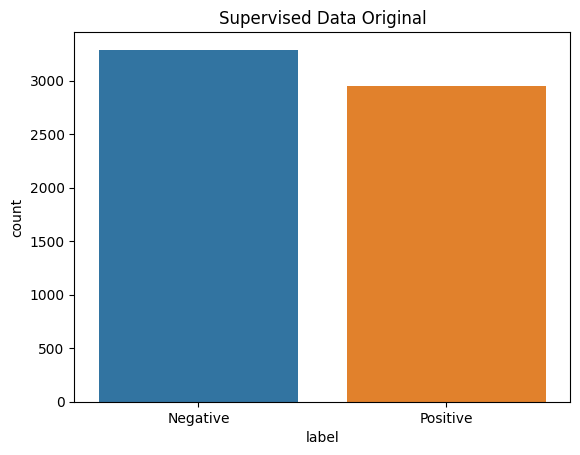

In [30]:

print(df['label'].value_counts())

# make bar plot from negative and positive lexicon
sns.countplot(x='label', data=df)
plt.title('Supervised Data Original')
plt.show()

In [31]:
def downsampling(df):
	df_minority = df[df.sentiment==1]
	df_minority_size = df_minority.shape[0]

	df_majority = df[df.sentiment==0]
	df_majority_size = df_majority.shape[0]
	df_majority_subject = df_majority.sample(n=df_minority_size, random_state=687)

	df_balanced	= pd.concat([df_majority_subject, df_minority])
	df_balanced.to_csv('../dataset/processed/supervised_tweets_downsampled.csv', index=False, header=True, sep=';')
	return df_balanced

def upsampling(df):
	df_majority = df[df.sentiment==0]
	df_minority = df[df.sentiment==1]
	df_minority_upsampled = resample(df_minority,
																			replace=True,
																			n_samples=len(df_majority),
																			random_state=687)
	df_balanced = pd.concat([df_majority, df_minority_upsampled])
	df_balanced.to_csv('../dataset/processed/supervised_tweets_upsampled.csv', index=False, header=True, sep=';')
	return df_balanced

Negative    3289
Positive    3289
Name: label, dtype: int64


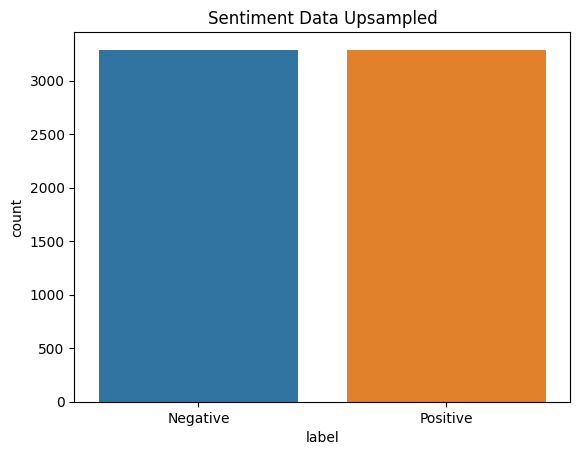

In [32]:
df_upsampled = upsampling(df)
print(df_upsampled['label'].value_counts())

# make bar plot from negative and positive sentiment
sns.countplot(x='label', data=df_upsampled)
plt.title('Sentiment Data Upsampled')
plt.show()

Negative    2948
Positive    2948
Name: label, dtype: int64


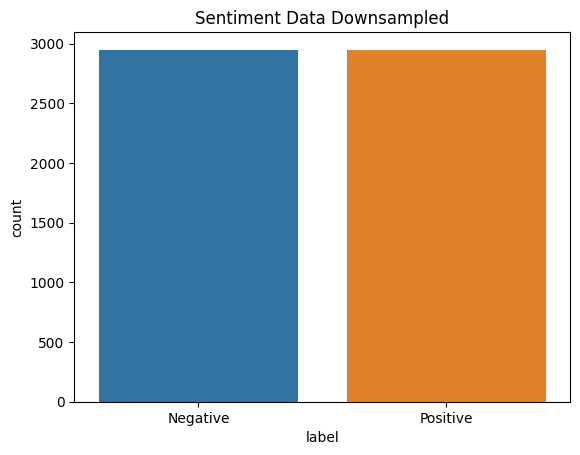

In [33]:
df_downsampled = downsampling(df)
print(df_downsampled['label'].value_counts())

# make bar plot from negative and positive sentiment
sns.countplot(x='label', data=df_downsampled)
plt.title('Sentiment Data Downsampled')
plt.show()

In [34]:
text = 'cinta pertamina'
print(determine_polarity(text))

2
